# 차원축소 Assignment2

## MNIST data에 적용을 해보기

mnist-original.mat 파일과 같은 위치에서 주피터 노트북을 열어주세요

In [1]:
import numpy as np
import pandas as pd
from scipy import io
from timeit import timeit
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

In [2]:
mnist = io.loadmat('mnist-original.mat') #mnist 손글씨 데이터를 불러옵니다
X = mnist['data'].T
y = mnist['label'].T

# 데이터 정보!
- 7만개의 작은 숫자 이미지
- 행 열이 반대로 되어있음 -> 전치
- grayscale 28x28 pixel = 784 feature
- 각 pixel은 0~255의 값
- label = 1~10 label이 총 10개인거에 주목하자

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000, 1)


In [4]:
# data를 각 픽셀에 이름붙여 표현
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# df에 라벨 y를 붙여서 데이터프레임 생성
df['y'] = y
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


In [6]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0


<Figure size 640x480 with 0 Axes>

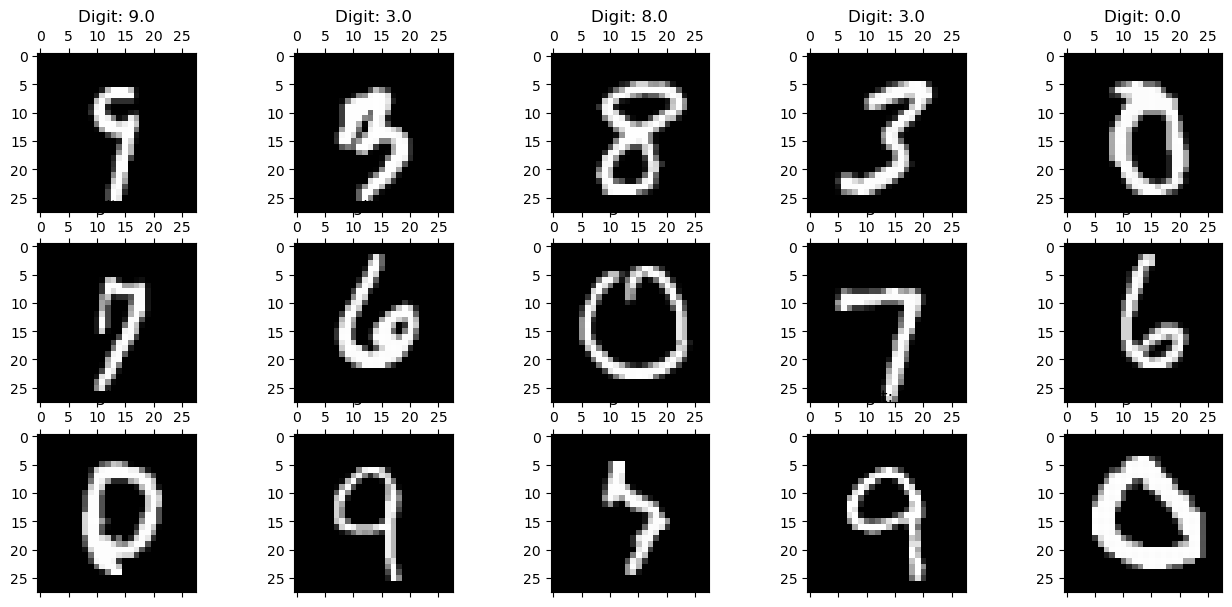

In [7]:
# 데이터 형태 시각화
rndperm = np.random.permutation(df.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'y'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

### 1) train_test_split을 통해 데이터를 0.8 0.2의 비율로 분할 해 주세요

In [8]:
train, test = train_test_split(df, test_size=0.2, stratify=df["y"], random_state=42)

In [9]:
train_x, train_y = train.drop(columns=["y"], inplace=False), train["y"]
test_x, test_y = test.drop(columns=["y"], inplace=False), test["y"]

### 여기서부터는 원본데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교해주세요

### 2) 차원축소 기법(PCA와 LDA)을 이용하여 mnist data를 축소시켜주세요

pca를 이용할 때는, 주성분 개수를 정하는 과정에 대해 잘 서술해주시면 좋겠죠!<br>
강의에서 배웠던 3가지 중 어떤 걸 고려해서 갯수를 정했는지요!!!!<br>
scree plot같은거는 직접 그려서 확인해주면 좋겠죠???

In [10]:
# 최적의 주성분 개수를 확인하기 위해 scree plot 그리기
cumulative_explained_variance_ratio = []
for n in range(5, 51):
    pca = PCA(n_components=n)
    pca.fit(train_x)
    cumulative_explained_variance_ratio.append(pca.explained_variance_ratio_.sum())
else:
    explained_variance = pca.explained_variance_

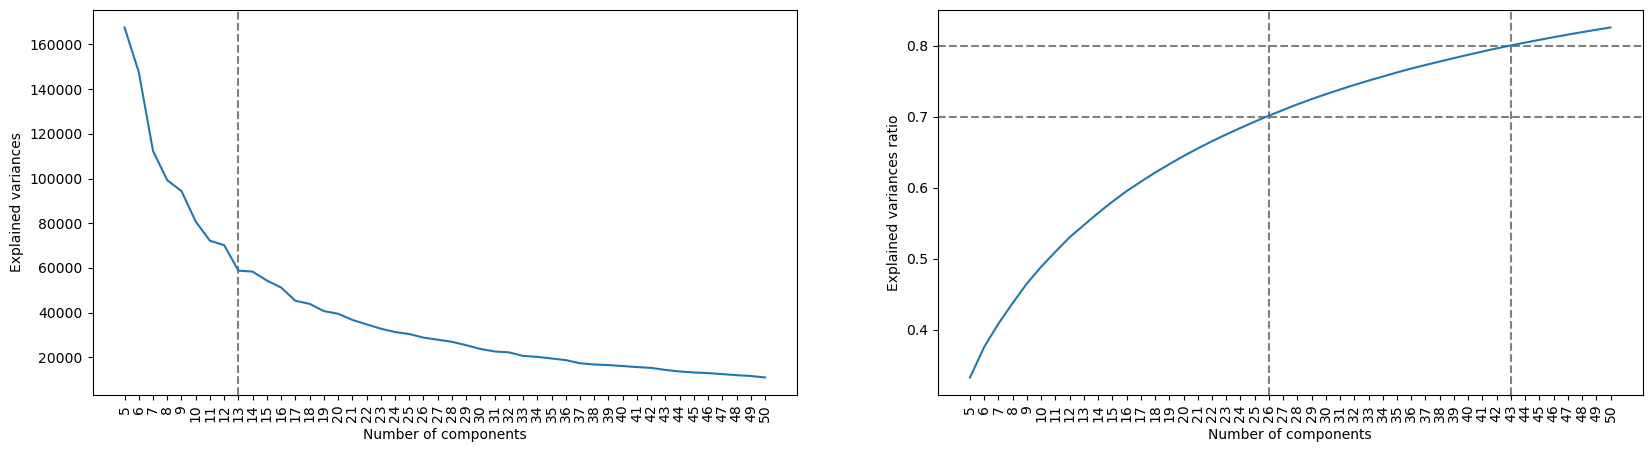

In [11]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.axvline(13, color="gray", ls="--")
plt.plot(range(5, 51), explained_variance[4:])
plt.xticks(np.arange(5, 51, step=1), rotation=90)
plt.xlabel("Number of components")
plt.ylabel("Explained variances")

plt.subplot(1, 2, 2)
plt.axhline(0.7, color="gray", ls="--")
plt.axvline(26, color="gray", ls="--")
plt.axhline(0.8, color="gray", ls="--")
plt.axvline(43, color="gray", ls="--")
plt.plot(range(5, 51), cumulative_explained_variance_ratio)
plt.xticks(np.arange(5, 51, step=1), rotation=90)
plt.xlabel("Number of components")
plt.ylabel("Explained variances ratio")

plt.show()

In [12]:
pca = PCA(n_components=43)
pca_reduced_train_x = pca.fit_transform(train_x)
pca_reduced_test_x = pca.transform(test_x)

In [13]:
cumulative_explained_variance_ratio = []
for n in range(1, 10):
    lda = LinearDiscriminantAnalysis(n_components=n)
    lda.fit(train_x, train_y)
    cumulative_explained_variance_ratio.append(lda.explained_variance_ratio_.sum())

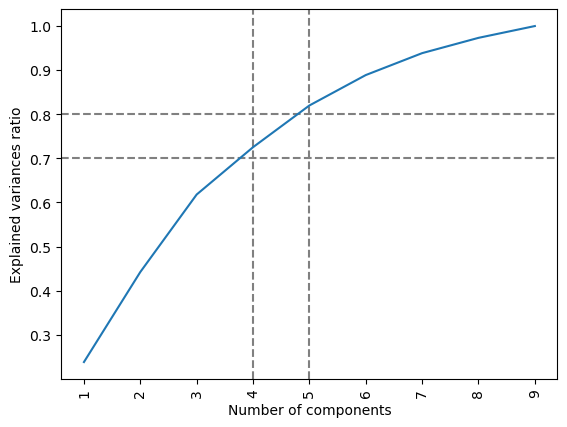

In [14]:
plt.axhline(0.7, color="gray", ls="--")
plt.axvline(4, color="gray", ls="--")
plt.axhline(0.8, color="gray", ls="--")
plt.axvline(5, color="gray", ls="--")
plt.plot(range(1, 10), cumulative_explained_variance_ratio)
plt.xticks(np.arange(1, 10, step=1), rotation=90)
plt.xlabel("Number of components")
plt.ylabel("Explained variances ratio")

plt.show()

In [15]:
lda = LinearDiscriminantAnalysis(n_components=5)
lda_reduced_train_x = lda.fit_transform(train_x, train_y)
lda_reduced_test_x = lda.transform(test_x)

### 3) 지금까지 배웠던 머신러닝 기법을 이용하여 학습해주세요 (2개이상 사용)

###  이때 time stamp를 찍어서 training 시간을 비교하고, test accuracy도 비교해주세요
#### (원본 데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교)

In [16]:
knn= KNeighborsClassifier()

training_time = timeit(lambda: knn.fit(train_x, train_y), number=1)
print(f"Training time of KNN: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(knn.predict(train_x.values), train_y)}")
print(f"Test accuracy: {accuracy_score(knn.predict(test_x.values), test_y)}")

Training time of KNN: 0.028098612999997385 seconds


/usr/local/Caskroom/miniconda/base/envs/tobigs-regular-session/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training accuracy: 0.9810714285714286


/usr/local/Caskroom/miniconda/base/envs/tobigs-regular-session/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Test accuracy: 0.9696428571428571


In [17]:
knn_pca_43 = KNeighborsClassifier()

training_time = timeit(lambda: knn_pca_43.fit(pca_reduced_train_x, train_y), number=1)
print(f"Training time of KNN: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(knn_pca_43.predict(pca_reduced_train_x), train_y)}")
print(f"Test accuracy: {accuracy_score(knn_pca_43.predict(pca_reduced_test_x), test_y)}")

Training time of KNN: 0.019319184999972094 seconds
Training accuracy: 0.9852321428571429
Test accuracy: 0.9750714285714286


In [18]:
knn_lda_5 = KNeighborsClassifier()

training_time = timeit(lambda: knn_lda_5.fit(lda_reduced_train_x, train_y), number=1)
print(f"Training time of KNN: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(knn_lda_5.predict(lda_reduced_train_x), train_y)}")
print(f"Test accuracy: {accuracy_score(knn_lda_5.predict(lda_reduced_test_x), test_y)}")

Training time of KNN: 0.050952628999993976 seconds
Training accuracy: 0.8788035714285715
Test accuracy: 0.8316428571428571


In [20]:
clf = RandomForestClassifier(random_state=42)

training_time = timeit(lambda: clf.fit(train_x, train_y), number=1)
print(f"Training time of Random Forest: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(clf.predict(train_x), train_y)}")
print(f"Test accuracy: {accuracy_score(clf.predict(test_x), test_y)}")

Training time of Random Forest: 36.595243622 seconds
Training accuracy: 1.0
Test accuracy: 0.9672142857142857


In [21]:
clf_pca_43 = RandomForestClassifier(random_state=42)
training_time = timeit(lambda: clf_pca_43.fit(pca_reduced_train_x, train_y), number=1)
print(f"Training time of Random Forest: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(clf_pca_43.predict(pca_reduced_train_x), train_y)}")
print(f"Test accuracy: {accuracy_score(clf_pca_43.predict(pca_reduced_test_x), test_y)}")

Training time of Random Forest: 58.059366932000046 seconds
Training accuracy: 1.0
Test accuracy: 0.9528571428571428


In [22]:
clf_lda_5 = RandomForestClassifier(random_state=42)
training_time = timeit(lambda: clf_lda_5.fit(lda_reduced_train_x, train_y), number=1)
print(f"Training time of Random Forest: {training_time} seconds")

print(f"Training accuracy: {accuracy_score(clf_lda_5.predict(lda_reduced_train_x), train_y)}")
print(f"Test accuracy: {accuracy_score(clf_lda_5.predict(lda_reduced_test_x), test_y)}")

Training time of Random Forest: 19.347276408000027 seconds
Training accuracy: 1.0
Test accuracy: 0.8406428571428571
